In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
import time

In [10]:
img_width, img_height = 224, 224

In [11]:
data = ImageDataBunch.from_folder('data/','train','valid',ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),size=224,bs=32).normalize(imagenet_stats)

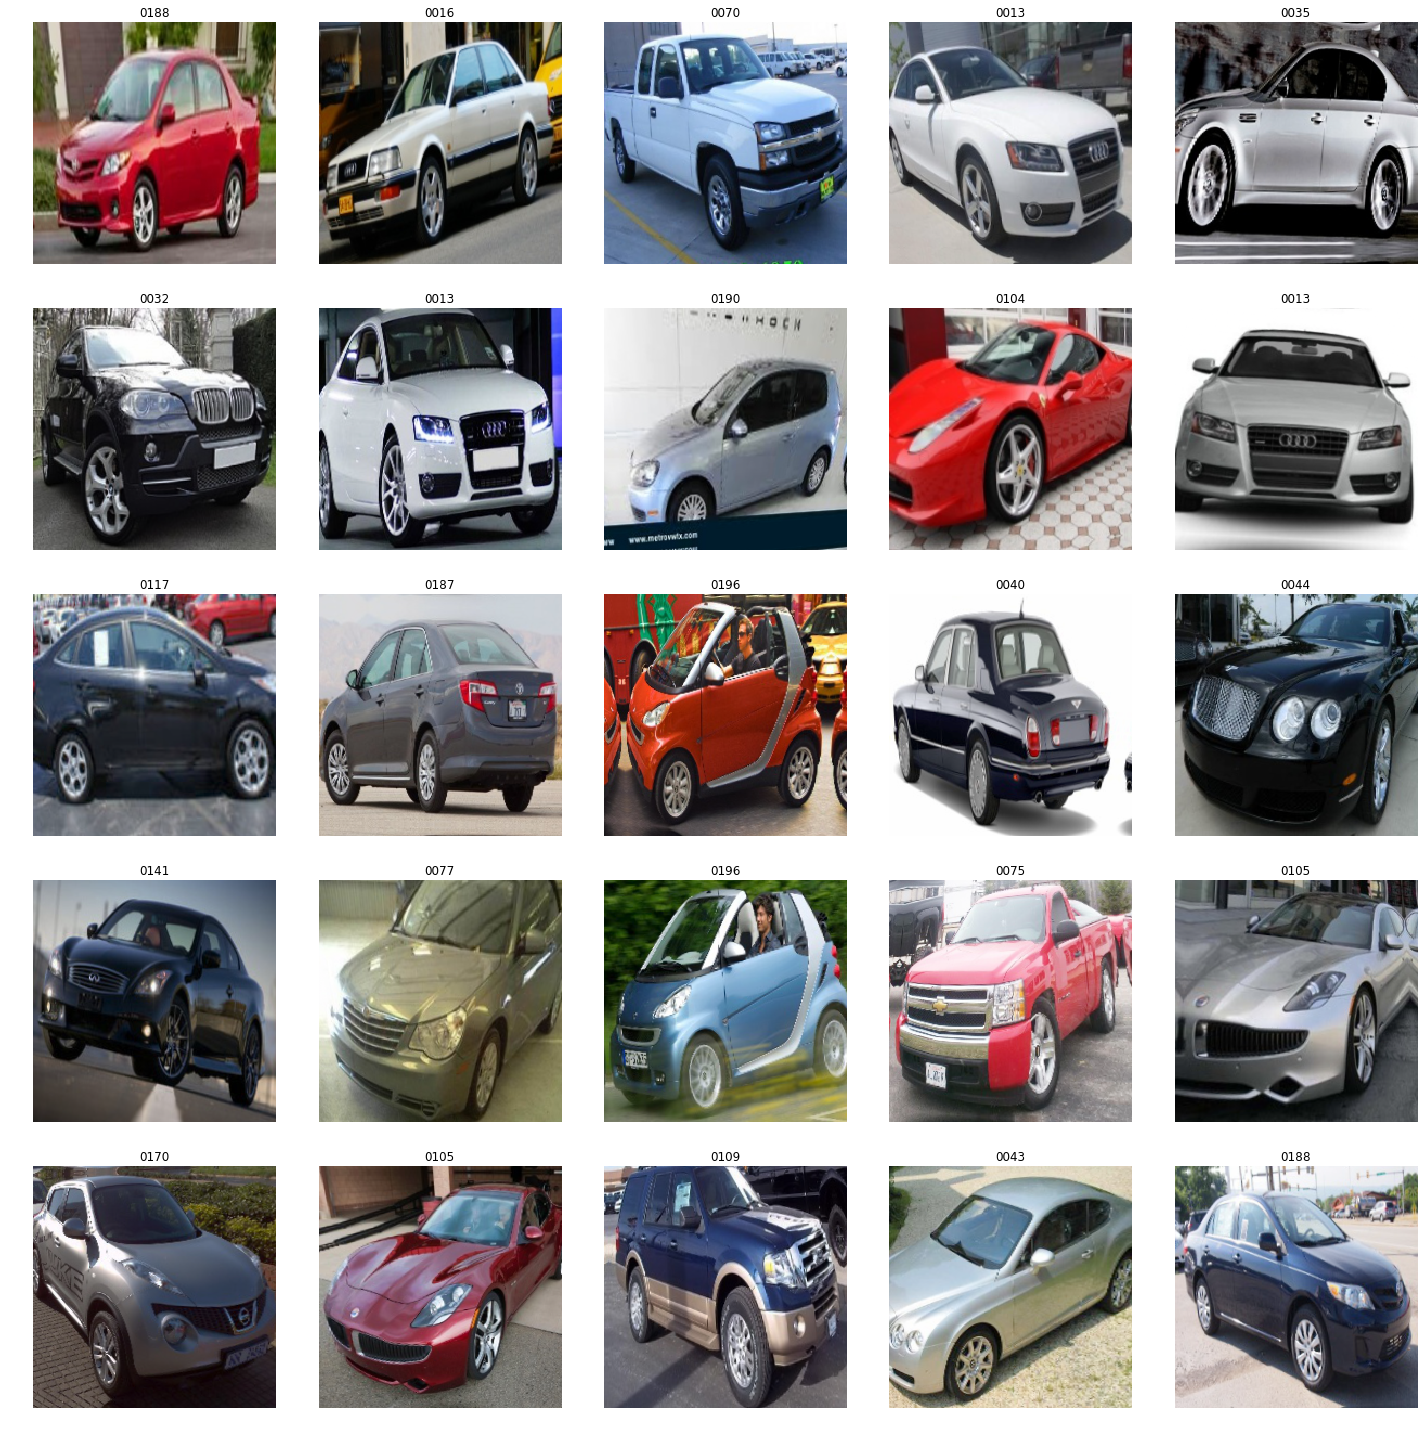

In [12]:
data.show_batch()

In [13]:
len(data.classes), data.c

(196, 196)

In [14]:
learn = cnn_learner(data, models.resnet101, metrics=accuracy).mixup()

In [8]:
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,5.369562,4.454594,0.100061,01:49
1,4.428622,3.382092,0.241252,01:46
2,3.728781,2.510757,0.395335,01:47
3,3.206679,1.927085,0.516882,01:47
4,2.846535,1.545069,0.616943,01:47
5,2.616287,1.373698,0.635973,01:47
6,2.444548,1.235166,0.696746,01:48
7,2.325131,1.102192,0.713321,01:48
8,2.145486,1.042448,0.736034,01:48
9,2.021537,0.994466,0.758134,01:47


In [9]:
preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0}.'.format(acc))

The accuracy is 0.7949662208557129.


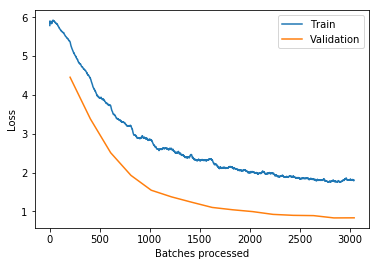

In [10]:
learn.recorder.plot_losses()

In [11]:
learn.save('cv-cars-resnet101-mixup-15e')

In [12]:
# RESULTS
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

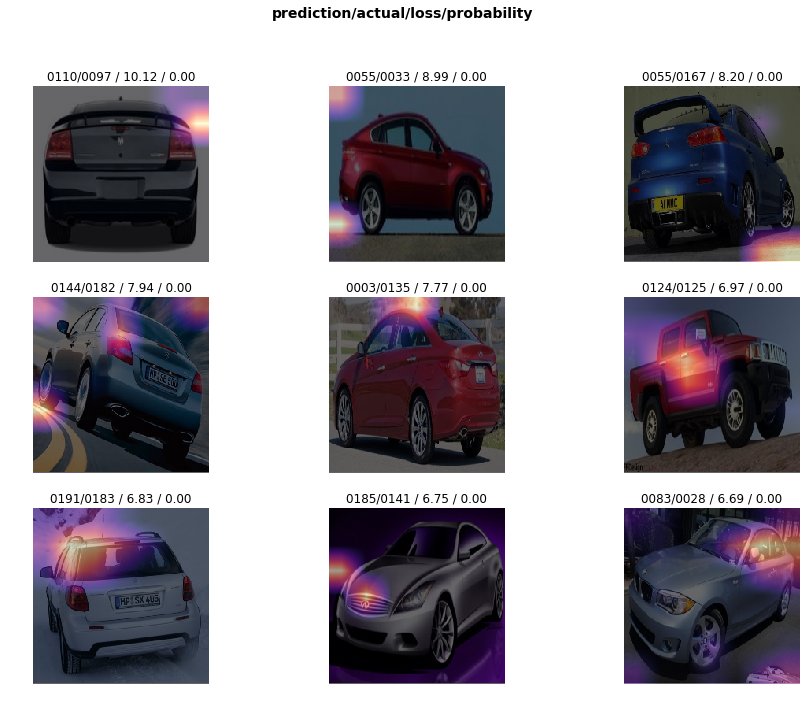

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


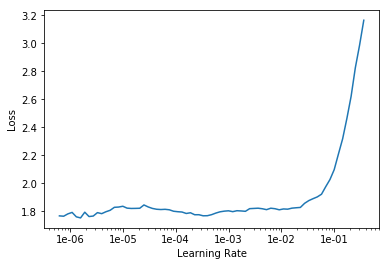

In [15]:
learn.recorder.plot()

In [16]:
learn.unfreeze()
learn.fit_one_cycle(40, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.932564,0.812455,0.793738,02:19
1,1.987269,0.860719,0.775322,02:21
2,2.026856,1.033219,0.737876,02:21
3,2.233604,1.318540,0.667281,02:22
4,2.430935,1.582818,0.609576,02:21
5,2.441329,1.316932,0.670964,02:21
6,2.550349,1.466651,0.604665,02:21
7,2.410046,1.451816,0.627993,02:21
8,2.386913,1.213875,0.691222,02:21
9,2.342399,1.254972,0.669122,02:21


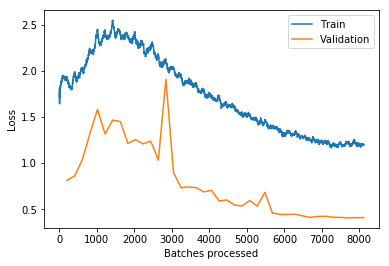

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.save('cv-cars-resnet101-mixup-1e-4-1e-2lr-40e')

In [19]:
learn.export('/home/jupyter/ai-for-sea/data/export-rn101-40e.pkl')

## Write Results

In [5]:
learn = load_learner('/home/jupyter/ai-for-sea/data/', file='export-rn101-40e.pkl', test= ImageList.from_csv('//home//jupyter//ai-for-sea//data//','test_labels.csv',folder='//test'))
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [6]:
a=preds;a.shape

torch.Size([8041, 196])

In [7]:
labels = scipy.io.loadmat('//home//jupyter//ai-for-sea//data//cars_test_annos_withlabels.mat')

In [8]:
b=np.array(labels['annotations']['class'],dtype=np.int)-1;b.shape #labels in range [0..195]
b = torch.from_numpy(b)

In [9]:
acc=accuracy(a,b);acc

tensor(0.9123)

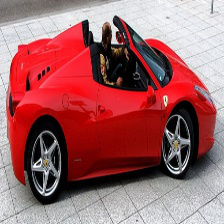

In [10]:
img = open_image(os.path.join('data/test', '%05d.jpg' % (1 + 1)))
img

In [11]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx.item()

(Category 0103, 102)

In [12]:
def write_prediction(num_samples):
    start = time.time()
    out = open('result-101-e40.txt', 'a')
    for i in range(num_samples):
        filename = os.path.join('data/test', '%05d.jpg' % (i + 1))
        img = open_image(filename)
        pred_class,pred_idx,outputs = learn.predict(img)
        class_id = int(repr(pred_class).split(' ')[1])
        out.write('{}\n'.format(str(class_id)))

    end = time.time()
    seconds = end - start
    print('avg fps: {}'.format(str(num_samples / seconds)))

    out.close()

In [13]:
write_prediction(8041)

avg fps: 51.76926592588525


## Some More Experimentation

In [15]:
learn.load('cv-cars-resnet101-mixup-15e')

Learner(data=ImageDataBunch;

Train: LabelList (6515 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0116,0116,0116,0116,0116
Path: data;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0116,0116,0116,0116,0116
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64,

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


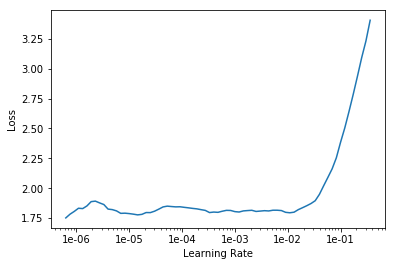

In [17]:
learn.recorder.plot()

In [21]:
div_lr = 3
lr = 1e-2
lrs = np.array([lr/(div_lr**2), lr/div_lr, lr])
lrs

array([0.001111, 0.003333, 0.01    ])

In [22]:
learn.unfreeze()
learn.fit_one_cycle(40, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,2.236484,1.020865,0.745242,02:20
1,2.316535,1.441420,0.627993,02:19
2,2.501873,1.677423,0.562922,02:19
3,2.666450,1.903784,0.508287,02:19
4,2.764652,2.223999,0.427870,02:19
5,2.891864,2.652289,0.392879,02:19
6,2.804487,2.108406,0.460405,02:19
7,2.822936,1.909618,0.516268,02:18
8,2.784558,2.427791,0.414365,02:18
9,2.749110,1.888350,0.510743,02:18


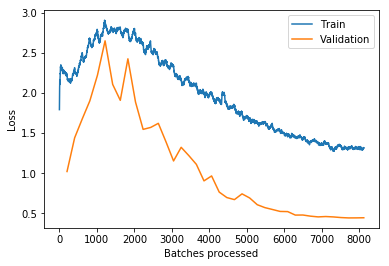

In [23]:
learn.recorder.plot_losses()